In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from scipy import spatial

In [2]:
# Stopwords in french (no information)
stopwords_fr = []
with open("data/stopwords/stopwords-fr.txt", 'r', encoding='utf-8') as f:
    stopwords_fr = f.readlines()
    stopwords_fr = [w.strip() for w in stopwords_fr]
stopwords_fr[:10]

['a', 'à', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies']

In [3]:
stopwords_fr.remove('o|')

In [4]:
# punctations in french (no information)
punctuations_fr = "\"$%&'?!()*+,-./:;=@[\]^_`{|}'~«»´’–"

In [5]:
# Load all the tweets
party_tweets = pd.read_csv("data/twitter_data/party_tweets.csv")
member_tweets = pd.read_csv("data/twitter_data/merged_member_tweets.csv")

In [6]:
# Adding a new column called year and which contains the year of the tweets
def extract_year(tweets):
    tweets_copy = tweets.copy()
    tweets_copy['year'] = tweets_copy['timestamp'].str[-4:].astype(int)  
    return tweets_copy

In [7]:
# Add the years of the tweets
party_tweets = extract_year(party_tweets)
member_tweets = extract_year(member_tweets)

In [8]:
# Change name of a column to be coherent
party_tweets = party_tweets.rename(columns={'partyname': 'party_name'})

In [9]:
party_tweets.head()

id                       timestamp  party_name username  \
0  1196812925580840961  Tue Nov 19 15:30:11 +0000 2019  UDC Suisse    UDCch   
1  1196375024124538880  Mon Nov 18 10:30:07 +0000 2019  UDC Suisse    UDCch   
2  1189851774510874624  Thu Oct 31 10:29:04 +0000 2019  UDC Suisse    UDCch   
3  1187013387508748288  Wed Oct 23 14:30:19 +0000 2019  UDC Suisse    UDCch   
4  1186266665358647298  Mon Oct 21 13:03:07 +0000 2019  UDC Suisse    UDCch   

                                          tweet_text all_hashtags  \
0  Durant la session d’hiver à venir, le Parlemen...           []   
1  Le glissement à gauche, qui a eu lieu lors des...           []   
2  Au lieu d'attaquer le mal à la racine, le Cons...           []   
3  Les conséquences nuisibles de l’immigration dé...           []   
4  «Un tout grand Merci à toutes les électrices e...           []   

  all_mentions                                           all_urls  \
0           []  ['https://www.udc.ch/actualites/articles/commu...   
1           []  ['https://www.udc.ch/actualites/articles/commu...   
2           []  ['https://www.udc.ch/actualites/articles/commu...   
3           []  ['https://www.udc.ch/actualites/articles/commu...   
4           []                                                 []   

   retweet_count  favorite_count  range lang  year  
0              0               5    259   fr  2019  
1              1               9    218   fr  2019  
2              2               7    145   fr  2019  
3              3              17    208   fr  2019  
4              7              28    272   fr  2019

In [10]:
member_tweets.head()

id                       timestamp       member_name  \
0  1196747623471996928  Tue Nov 19 11:10:42 +0000 2019  Christian Levrat   
1  1196741312264970240  Tue Nov 19 10:45:37 +0000 2019  Christian Levrat   
2  1196064766248280066  Sun Nov 17 13:57:16 +0000 2019  Christian Levrat   
3  1193533989333749760  Sun Nov 10 14:20:52 +0000 2019  Christian Levrat   
4  1193083434790531073  Sat Nov 09 08:30:31 +0000 2019  Christian Levrat   

  party_name         username  \
0  PS Suisse  ChristianLevrat   
1  PS Suisse  ChristianLevrat   
2  PS Suisse  ChristianLevrat   
3  PS Suisse  ChristianLevrat   
4  PS Suisse  ChristianLevrat   

                                          tweet_text all_hashtags  \
0  @patoudoux @nantermod Heureux pays... petits s...           []   
1  RT @MikeMuellerLate: Liebe @claudia_blumer, ge...           []   
2  Des résultats convaincants, voire époustouflan...           []   
3  Alors qu’on attend toujours les résultats (ent...           []   
4  Merci d’y penser, de faire un effort et de pas...           []   

                                        all_mentions all_urls  retweet_count  \
0                         ['patoudoux', 'nantermod']       []              0   
1  ['MikeMuellerLate', 'claudia_blumer', 'tagesan...       []             27   
2  ['MarinaCarobbio', 'zanettiroberto', 'PaulRech...       []             13   
3                                                 []       []             16   
4                                                 []       []              7   

   favorite_count  range lang  year  
0               5     56   fr  2019  
1               0    140   de  2019  
2              98    159   fr  2019  
3              89    106   fr  2019  
4              41    194   fr  2019

In [11]:
party_tweets['party_name'].unique()

array(['UDC Suisse', 'PS Suisse', 'PLR Suisse', 'Les VERTS suisses 🌻',
       "Vert'libéraux Suisse", 'SVP Schweiz', 'SP Schweiz', 'FDP Schweiz',
       'GRÜNE Schweiz 🌻', 'Grünliberale Schweiz', 'CVP PDC PPD PCD'],
      dtype=object)

In [12]:
# Replace the german names of the parties by the french ones 
party_tweets.loc[(party_tweets.party_name == 'SVP Schweiz'), 'party_name'] = 'UDC Suisse'
party_tweets.loc[(party_tweets.party_name == 'SP Schweiz'), 'party_name'] = 'PS Suisse'
party_tweets.loc[(party_tweets.party_name == 'FDP Schweiz'), 'party_name'] = 'PLR Suisse'
party_tweets.loc[(party_tweets.party_name == 'GRÜNE Schweiz 🌻'), 'party_name'] = 'Les VERTS suisses 🌻'
party_tweets.loc[(party_tweets.party_name == 'Grünliberale Schweiz'), 'party_name'] = "Vert'libéraux Suisse"
party_tweets['party_name'].unique()

array(['UDC Suisse', 'PS Suisse', 'PLR Suisse', 'Les VERTS suisses 🌻',
       "Vert'libéraux Suisse", 'CVP PDC PPD PCD'], dtype=object)

In [13]:
member_tweets['party_name'].unique()

array(['PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'],
      dtype=object)

In [14]:
# Group all the tweets (member + party) in one dataframe 
tweets = pd.concat([party_tweets, member_tweets], sort=True)
tweets

all_hashtags                          all_mentions  \
0                        []                                    []   
1                        []                                    []   
2                        []                                    []   
3                        []                                    []   
4                        []                                    []   
...                     ...                                   ...   
132835           ['Ecopop']                                    []   
132836        ['Swissness']       ['silvan_z', 'AargauerZeitung']   
132837  ['Innovationspark']  ['BaSchaffner', 'RuediNoser', 'NZZ']   
132838  ['Innovationspark']                               ['NZZ']   
132839                   []                             ['mhegi']   

                                                 all_urls  favorite_count  \
0       ['https://www.udc.ch/actualites/articles/commu...               5   
1       ['https://www.udc.ch/actualites/articles/commu...               9   
2       ['https://www.udc.ch/actualites/articles/commu...               7   
3       ['https://www.udc.ch/actualites/articles/commu...              17   
4                                                      []              28   
...                                                   ...             ...   
132835                                                 []              31   
132836                             ['http://ow.ly/Ew1k8']               1   
132837                                                 []               0   
132838                           ['http://ow.ly/i/7BDgb']               1   
132839                                                 []               1   

                         id lang  member_name  party_name  range  \
0       1196812925580840961   fr          NaN  UDC Suisse    259   
1       1196375024124538880   fr          NaN  UDC Suisse    218   
2       1189851774510874624   fr          NaN  UDC Suisse    145   
3       1187013387508748288   fr          NaN  UDC Suisse    208   
4       1186266665358647298   fr          NaN  UDC Suisse    272   
...                     ...  ...          ...         ...    ...   
132835   535102663692914689   de  Ruedi Noser  PLR Suisse    103   
132836   535016276029374464   de  Ruedi Noser  PLR Suisse     82   
132837   534340108951244800   de  Ruedi Noser  PLR Suisse    140   
132838   534259720618381312   de  Ruedi Noser  PLR Suisse     96   
132839   533916376315207680   de  Ruedi Noser  PLR Suisse     38   

        retweet_count                       timestamp  \
0                   0  Tue Nov 19 15:30:11 +0000 2019   
1                   1  Mon Nov 18 10:30:07 +0000 2019   
2                   2  Thu Oct 31 10:29:04 +0000 2019   
3                   3  Wed Oct 23 14:30:19 +0000 2019   
4                   7  Mon Oct 21 13:03:07 +0000 2019   
...               ...                             ...   
132835             21  Wed Nov 19 16:09:51 +0000 2014   
132836              0  Wed Nov 19 10:26:34 +0000 2014   
132837              1  Mon Nov 17 13:39:44 +0000 2014   
132838              1  Mon Nov 17 08:20:18 +0000 2014   
132839              0  Sun Nov 16 09:35:58 +0000 2014   

                                               tweet_text    username  year  
0       Durant la session d’hiver à venir, le Parlemen...       UDCch  2019  
1       Le glissement à gauche, qui a eu lieu lors des...       UDCch  2019  
2       Au lieu d'attaquer le mal à la racine, le Cons...       UDCch  2019  
3       Les conséquences nuisibles de l’immigration dé...       UDCch  2019  
4       «Un tout grand Merci à toutes les électrices e...       UDCch  2019  
...                                                   ...         ...   ...  
132835  Auch wenn wir uns in der 30% Marke befinden – ...  RuediNoser  2014  
132836  Verordnungsstress um #Swissness. @silvan_z @Aa...  RuediNoser  2014  
132837  RT @BaSchaffner: @RuediNoser @NZZ Deshalb JA z...

In [15]:
print("Years of activity for each party: ")
years_UDC = party_tweets[party_tweets.party_name=='UDC Suisse']['year'].unique()
print("UDC: %s" % years_UDC)
years_PS = party_tweets[party_tweets.party_name=='PS Suisse']['year'].unique()
print("PS: %s" % years_PS)
years_PLR = party_tweets[party_tweets.party_name=='PLR Suisse']['year'].unique()
print("PLR: %s" % years_PLR)
years_VERTS = party_tweets[party_tweets.party_name=='Les VERTS suisses 🌻']['year'].unique()
print("VERTS: %s" % years_VERTS)
years_VERTS_LIB = party_tweets[party_tweets.party_name=="Vert'libéraux Suisse"]['year'].unique()
print("VERTS LIB: %s" % years_VERTS_LIB)
years_PDC = party_tweets[party_tweets.party_name=='CVP PDC PPD PCD']['year'].unique()
print("PDC: %s" % years_PDC)

Years of activity for each party: 
UDC: [2019 2018 2017 2016 2015 2014 2013]
PS: [2019 2018 2017 2016 2015 2014 2013 2012 2011]
PLR: [2019 2018 2017 2016 2015]
VERTS: [2019 2018 2017 2016 2015 2014 2013 2012 2011 2010]
VERTS LIB: [2019 2018 2017 2016 2015 2014 2012 2011 2010]
PDC: [2019 2018 2017]


# Keywords of parties

In [16]:
from collections import Counter

YEARS = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]

def tweets_to_text(tweets, lang, party_name, year=YEARS, dictionary_words = False , dictionary = None):
    """
    Returns a text of all the tweets of a party after processing them.
    
    lang: {'fr','de'}
    username: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    year: default = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
    """
    tweets_copy = tweets.copy()
    tweets_copy = tweets_copy[tweets_copy.lang==lang]
    tweets_copy = tweets_copy[tweets_copy.party_name==party_name]
    tweets_copy = tweets_copy[tweets_copy['year'].isin(year)]
    tweets_copy = tweets_copy["tweet_text"].str.lower()

    text = ""
    for t in tweets_copy:
        text += ' ' +  t
    
    text = re.sub(r'https:\/\/t\.co\/.{10}', '', text)
    text = re.sub(r'http:\/\/t\.co\/.{10}', '', text)
    
    if (lang=='fr'):
        for c in punctuations_fr:
            text = text.replace(c, ' ')
        for w in stopwords_fr:
            regex = r" " + w + " "
            text = re.sub(regex, ' ', text)
        text = text.replace('  ', ' ')
        text = text.replace('  ', ' ')
        text = text.replace('  ', ' ')
        
        if dictionary_words:
            splitted_text = text.split()
            text = [t for t in splitted_text if t in dictionary]
        return text
    else:
        raise NotImplementedError # TODO    

def text_to_bag(text, dictionary_words = False):
    """
    Return a bag of word sorted by frequency given a text
    """
    if dictionary_words:
        return Counter(text).most_common()
    else:
        return Counter(text.split(" ")).most_common()


In [17]:
# Generating the text for all parties:
VERTS_text = tweets_to_text(tweets, lang='fr', party_name='Les VERTS suisses 🌻')
UDC_text = tweets_to_text(tweets, lang='fr', party_name='UDC Suisse')
PLR_text = tweets_to_text(tweets, lang='fr', party_name='PLR Suisse')
PDC_text = tweets_to_text(tweets, lang='fr', party_name='CVP PDC PPD PCD')
PS_text = tweets_to_text(tweets, lang='fr', party_name='PS Suisse')
VERTS_LIB_text = tweets_to_text(tweets, lang='fr', party_name="Vert'libéraux Suisse")

In [18]:
import nltk #import the natural language toolkit library
from nltk.stem.snowball import FrenchStemmer #import the French stemming library

    
def stem_words(words):
    '''stems the word list using the French Stemmer'''
    #stemming words
    stemmed_words = [] #declare an empty list to hold our stemmed words
    stemmer = FrenchStemmer() #create a stemmer object in the FrenchStemmer class
    for word in words:
        stemmed_word=stemmer.stem(word) #stem the word
        stemmed_words.append(stemmed_word) #add it to our stemmed word list
    stemmed_words.sort() #sort the stemmed_words
    return stemmed_words
   

In [20]:
stemmed_words = stem_words(re.sub(r'\d', ' ', re.sub(r'#', ' ', VERTS_text)).split())
stemmed_words

['a',
 'a',
 'a',
 'a',
 'aa',
 'aaaposit',
 'aaaposit',
 'aai',
 'aargau',
 'aargau',
 'ab',
 'abaiss',
 'abandon',
 'abandon',
 'abandon',
 'abandon',
 'abandonnent',
 'abattag',
 'abattoirs…',
 'abattr',
 'abattr',
 'abattr',
 'abattr',
 'abattr',
 'abattr',
 'abattr',
 'abattr',
 'abattr',
 'abattu',
 'abattu',
 'abattu',
 'abattu',
 'abattus',
 'abb',
 'abbay',
 'abec',
 'abeil',
 'abeil',
 'abeil',
 'abeil',
 'abeil',
 'aberr',
 'aberr',
 'aberr',
 'aberr',
 'aberr',
 'aberr',
 'abgi',
 'abol',
 'abolit',
 'abolit',
 'abolit',
 'abon',
 'abon',
 'abon',
 'abon',
 'abon',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'abord',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'about',
 'abou

In [21]:
VERTS_bag = text_to_bag(VERTS_text)

In [22]:
UDC_bag = text_to_bag(UDC_text)

In [23]:
PLR_bag = text_to_bag(PLR_text)

In [24]:
PDC_bag = text_to_bag(PDC_text)

In [25]:
PS_bag = text_to_bag(PS_text)

In [26]:
VERTS_LIB_bag = text_to_bag(VERTS_LIB_text)

# Political topics

In [27]:
# Partially based on https://www.rts.ch/info/suisse/10732046-les-primes-maladie-perdraient-en-influence-sur-les-choix-electoraux.html
topic_list_reg = {'Climate':'climat|environnement|co2',
                'Immigration':'migration|asile|étranger|réfugié',
                'Safety':'sécurité|crimi|crime|sûr\b|sûre\b',
                'Liberty':'liberté|libre',
                'Egality':'égalit|solida',
                'Economy':'économi|marché',
                'Work':'travail|emploi|entreprise|chômage|chômeur|salaire|salarial',
                'Women':'femme',
                'Digital':'numérique|internet|digital',
                'Family':'famille|mariage|enfant',
                'AVS':'avs',
                'Health':'santé|maladie|médecin',
                'Europe':'europ| ue |#ue',
                'Army':'armée|militair|militaris|gripen'
                  }

In [28]:
from re import search
# Helpers methods

# Keep only the values of the topics list 
def topic_list_to_regex(topic_list):
    list_keywords = list(topic_list.values())
    keywords = ''
    for k in list_keywords:
        keywords = keywords + '|' + k
    return keywords[1:]

# Transform a bag of words into a dictionnary
def bag_to_dict(bag):
    dic = {}
    for b in bag:
        word = b[0]
        count = b[1]
        dic.update({word : count})
    return dic

# Keep only the keywords of a dictionnary
def keep_keywords(dic, keywords):
    dic_key = {}
    for key in dic:
        if search(keywords, key) or key == 'ue':
            dic_key.update({key:dic.get(key)})
    return dic_key

# The frequency of each topic
def freq_by_topic(dic_key, num_words, topic_list):
    dic_numbers = {}
    for key, value in topic_list.items():
        count = 0
        for d in dic_key:
            if search(value, d) or (d == 'ue' and key == 'Europe'):
                count += dic_key.get(d)
        freq = 100 * count/num_words
        dic_numbers.update({key:freq})
    return dic_numbers

In [29]:
def bag_to_keywords_frequency(bag, topic_list_reg):
    """
    Return the frequency (%) of the occurences of the words
    of a given topics_list in a bag of words
    """
    keywords = topic_list_to_regex(topic_list_reg)
    dic = bag_to_dict(bag)
    dic_key = keep_keywords(dic, keywords)
    return freq_by_topic(dic_key, np.array((list(dic_key.values()))).sum(), topic_list_reg)

In [30]:
bag_to_keywords_frequency(UDC_bag, topic_list_reg)

{'Climate': 4.335664335664336,
 'Immigration': 25.874125874125873,
 'Safety': 7.4125874125874125,
 'Liberty': 15.664335664335665,
 'Egality': 0.6993006993006993,
 'Economy': 7.8321678321678325,
 'Work': 8.391608391608392,
 'Women': 3.076923076923077,
 'Digital': 0.0,
 'Family': 2.937062937062937,
 'AVS': 3.2167832167832167,
 'Health': 1.3986013986013985,
 'Europe': 18.041958041958043,
 'Army': 1.118881118881119}

In [31]:
bag_to_keywords_frequency(VERTS_bag, topic_list_reg)

{'Climate': 49.053857350800584,
 'Immigration': 3.3478893740902476,
 'Safety': 2.5036390101892287,
 'Liberty': 2.037845705967977,
 'Egality': 6.3755458515283845,
 'Economy': 10.334788937409025,
 'Work': 6.550218340611353,
 'Women': 5.502183406113537,
 'Digital': 1.5138282387190685,
 'Family': 3.2605531295487626,
 'AVS': 0.7860262008733624,
 'Health': 2.561863173216885,
 'Europe': 4.570596797671033,
 'Army': 1.6593886462882097}

In [32]:
bag_to_keywords_frequency(PS_bag, topic_list_reg)

{'Climate': 7.685241886099204,
 'Immigration': 7.424984690753215,
 'Safety': 4.6999387630128595,
 'Liberty': 3.551745254133497,
 'Egality': 9.38456827924066,
 'Economy': 5.251071647274954,
 'Work': 19.96325780771586,
 'Women': 10.134721371708512,
 'Digital': 1.6993263931414575,
 'Family': 6.981016533986528,
 'AVS': 6.12369871402327,
 'Health': 5.909369259032456,
 'Europe': 9.415186772810777,
 'Army': 2.005511328842621}

In [33]:
bag_to_keywords_frequency(PLR_bag, topic_list_reg)

{'Climate': 8.999192897497982,
 'Immigration': 8.071025020177563,
 'Safety': 5.246166263115415,
 'Liberty': 9.887005649717514,
 'Egality': 2.9862792574656982,
 'Economy': 12.267958030669895,
 'Work': 16.505246166263117,
 'Women': 4.519774011299435,
 'Digital': 7.38498789346247,
 'Family': 5.5690072639225185,
 'AVS': 4.560129136400323,
 'Health': 5.044390637610976,
 'Europe': 7.828894269572236,
 'Army': 1.1702986279257466}

In [34]:
bag_to_keywords_frequency(PDC_bag, topic_list_reg)

{'Climate': 3.7493579866461224,
 'Immigration': 7.139188495120698,
 'Safety': 6.163328197226503,
 'Liberty': 4.057524396507447,
 'Egality': 3.5439137134052388,
 'Economy': 8.988186954288649,
 'Work': 11.658962506420133,
 'Women': 4.4684129429892145,
 'Digital': 2.362609142270159,
 'Family': 13.507960965588085,
 'AVS': 7.704160246533128,
 'Health': 14.586543400102721,
 'Europe': 7.036466358500257,
 'Army': 5.290190035952747}

In [35]:
bag_to_keywords_frequency(VERTS_LIB_bag, topic_list_reg)

{'Climate': 26.951219512195124,
 'Immigration': 3.4146341463414633,
 'Safety': 5.487804878048781,
 'Liberty': 5.609756097560975,
 'Egality': 3.902439024390244,
 'Economy': 12.926829268292684,
 'Work': 8.902439024390244,
 'Women': 6.7073170731707314,
 'Digital': 0.8536585365853658,
 'Family': 7.804878048780488,
 'AVS': 1.5853658536585367,
 'Health': 2.1951219512195124,
 'Europe': 12.682926829268293,
 'Army': 0.975609756097561}

In [36]:
"""# Partially based on https://www.rts.ch/info/suisse/10732046-les-primes-maladie-perdraient-en-influence-sur-les-choix-electoraux.html
topics_list = {'Climate':['climat','#climat','climatique','environnement','co2','environnementale'],
                'Immigration':['immigration','asile','étranger','étrangers','réfugié','réfugiés','migration','migrations'],
                'Safety':['sécurité','criminalité'],
                'Liberty':['liberté','libre'],
                'Egality':['égalité','solidaire','solidarité'],
                'Economy':['économie','économies','économique','économiques','marché'],
                'Work':['travail','emploi','emplois','entreprise','entreprises','chômage','chômeur','salaire','salaires','salariale','travailleurs','travailleurs'],
                'Women':['femme','femmes'],
                'Digital':['numérique','numériques','internet','digital'],
                'Family':['famille','familles','mariage','mariages','enfant','enfants'],
                'AVS':['avs'],
                'Health':['santé','maladie'],
                'Europe':['europe','ue','#ue','européen']
                  }"""

"# Partially based on https://www.rts.ch/info/suisse/10732046-les-primes-maladie-perdraient-en-influence-sur-les-choix-electoraux.html\ntopics_list = {'Climate':['climat','#climat','climatique','environnement','co2','environnementale'],\n                'Immigration':['immigration','asile','étranger','étrangers','réfugié','réfugiés','migration','migrations'],\n                'Safety':['sécurité','criminalité'],\n                'Liberty':['liberté','libre'],\n                'Egality':['égalité','solidaire','solidarité'],\n                'Economy':['économie','économies','économique','économiques','marché'],\n                'Work':['travail','emploi','emplois','entreprise','entreprises','chômage','chômeur','salaire','salaires','salariale','travailleurs','travailleurs'],\n                'Women':['femme','femmes'],\n                'Digital':['numérique','numériques','internet','digital'],\n                'Family':['famille','familles','mariage','mariages','enfant','enfants'],\n    

In [37]:
"""# Helpers methods

# Keep only the values of the topics list 
def topics_list_to_keyword(topics_list):
    list_keywords = list(topics_list.values())
    keywords = []
    for k in list_keywords:
        for l in range(0,len(k)):
            keywords.append(k[l])
    return keywords

# Transform a bag of words into a dictionnary
def bag_to_dictionnary(bag):
    dic = {}
    for b in bag:
        word = b[0]
        count = b[1]
        dic.update({word : count})
    return dic

# Keep only the keywords of a dictionnary
def keep_only_keywords(dic, keywords):
    dic_key = {}
    for k in keywords:
        if k in dic:
            dic_key.update({k:dic.get(k)})
    return dic_key

# The frequency of each topic
def frequency_by_topic(dic_key, num_words):
    dic_numbers = {}
    for key, value in topics_list.items():
        count = 0
        for v in value:
            if v in dic_key:
                count += dic_key.get(v)
        freq = 100 * count/num_words
        dic_numbers.update({key:freq})
    return dic_numbers
"""

'# Helpers methods\n\n# Keep only the values of the topics list \ndef topics_list_to_keyword(topics_list):\n    list_keywords = list(topics_list.values())\n    keywords = []\n    for k in list_keywords:\n        for l in range(0,len(k)):\n            keywords.append(k[l])\n    return keywords\n\n# Transform a bag of words into a dictionnary\ndef bag_to_dictionnary(bag):\n    dic = {}\n    for b in bag:\n        word = b[0]\n        count = b[1]\n        dic.update({word : count})\n    return dic\n\n# Keep only the keywords of a dictionnary\ndef keep_only_keywords(dic, keywords):\n    dic_key = {}\n    for k in keywords:\n        if k in dic:\n            dic_key.update({k:dic.get(k)})\n    return dic_key\n\n# The frequency of each topic\ndef frequency_by_topic(dic_key, num_words):\n    dic_numbers = {}\n    for key, value in topics_list.items():\n        count = 0\n        for v in value:\n            if v in dic_key:\n                count += dic_key.get(v)\n        freq = 100 * count

In [38]:
"""
def bag_to_kewords_frequency(bag, topics_list):
    
    Return the frequency (%) of the occurences of the words
    of a given topics_list in a bag of words
    
    
    keywords = topics_list_to_keyword(topics_list)
    dic = bag_to_dictionnary(bag)
    dic_key = keep_only_keywords(dic, keywords)
    return frequency_by_topic(dic_key, np.array((list(dic_key.values()))).sum())
"""

'def bag_to_kewords_frequency(bag, topics_list):\n    \n    Return the frequency (%) of the occurences of the words\n    of a given topics_list in a bag of words\n    \n    \n    keywords = topics_list_to_keyword(topics_list)\n    dic = bag_to_dictionnary(bag)\n    dic_key = keep_only_keywords(dic, keywords)\n    return frequency_by_topic(dic_key, np.array((list(dic_key.values()))).sum())\n'

### Generating the word cloud

In [39]:
def draw_wordcloud(image_file, text):
    """
    Draws a wordcloud based on a given image (logo of a party) and a given text.
    """
    mask = np.array(Image.open(image_file).convert('RGB'))
    wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(text)
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.pyplot.figure(figsize=[20,10])
    plt.pyplot.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.pyplot.axis("off")
    # store to file
    #plt.savefig("img/us_wine.png", format="png")
    plt.pyplot.show()

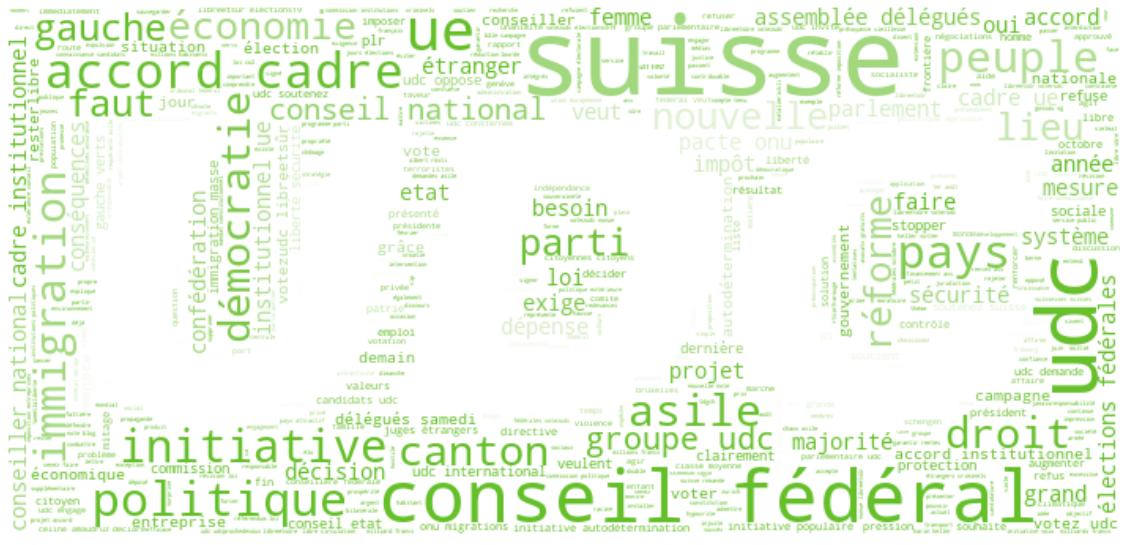

In [40]:
draw_wordcloud("data/logo/UDC_logo.jpg", UDC_text)

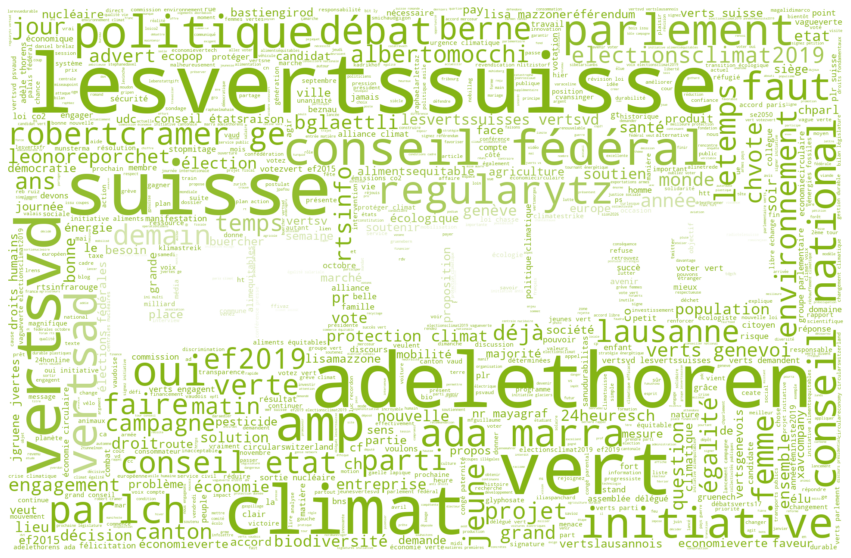

In [41]:
draw_wordcloud("data/logo/VERTS_logo.png", VERTS_text)

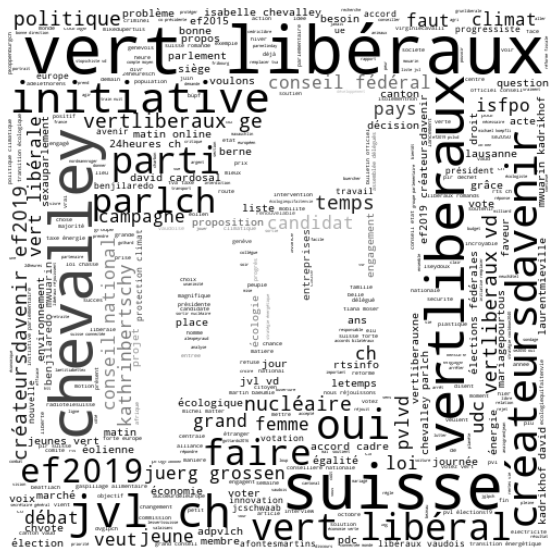

In [42]:
draw_wordcloud("data/logo/VERTS_LIB_logo.png", VERTS_LIB_text)

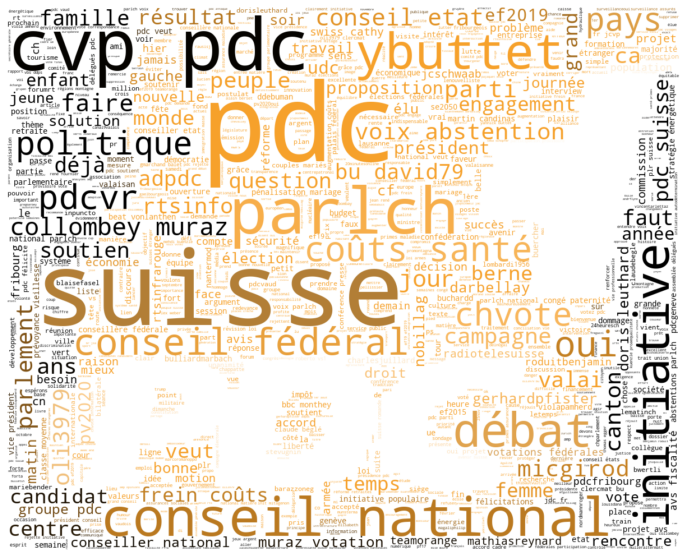

In [43]:
draw_wordcloud("data/logo/PDC_logo.png", PDC_text)

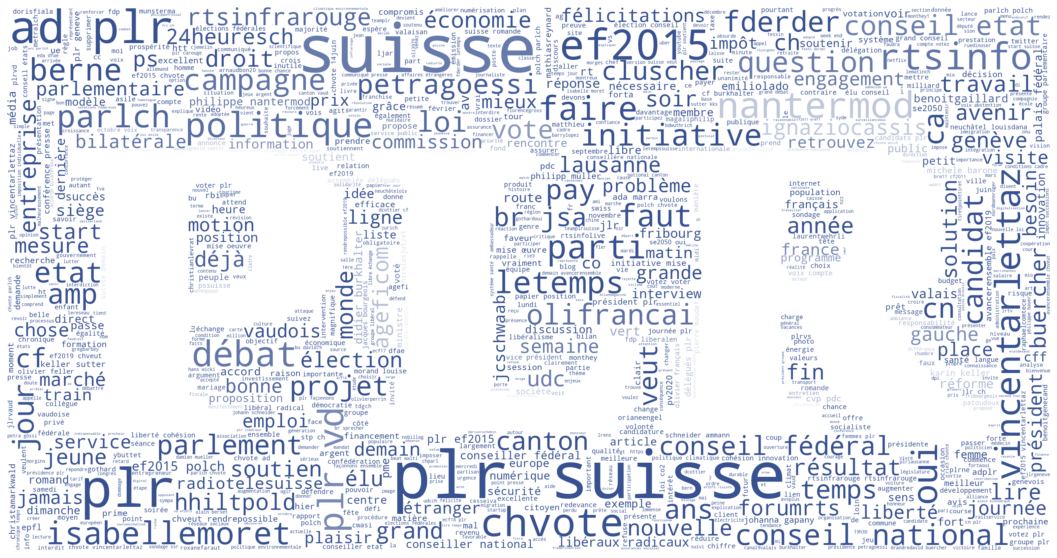

In [44]:
draw_wordcloud("data/logo/PLR_logo.png", PLR_text)

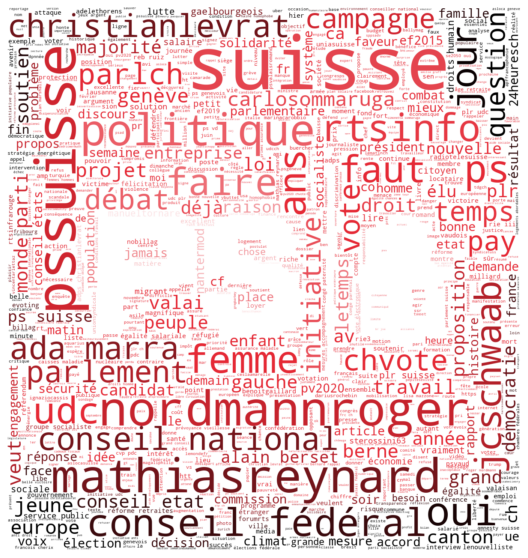

In [45]:
draw_wordcloud("data/logo/PS_logo.png", PS_text)

# Word2Vec


In [46]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [47]:
texts = [VERTS_text.split(" "), UDC_text.split(" "), PLR_text.split(" "), PDC_text.split(" "), VERTS_LIB_text.split(" "), PS_text.split(" ")]

In [55]:
keywords = topic_list_to_regex(topic_list_reg)

def text_to_keyword_list(text):
    keyword_list = []
    for word in text:
        if search(keywords, word) or word == 'ue':
            keyword_list.append(word)
    return keyword_list

In [56]:
UDC_list_keyword = text_to_keyword_list(UDC_text.split(" "))
PS_list_keyword = text_to_keyword_list(PS_text.split(" "))
PLR_list_keyword = text_to_keyword_list(PLR_text.split(" "))
PDC_list_keyword = text_to_keyword_list(PDC_text.split(" "))
VERTS_list_keyword = text_to_keyword_list(VERTS_text.split(" "))
VERTS_LIB_list_keyword = text_to_keyword_list(VERTS_LIB_text.split(" "))

parties_list_keyword = [UDC_list_keyword, PS_list_keyword, PLR_list_keyword, PDC_list_keyword, VERTS_list_keyword, VERTS_LIB_list_keyword]

In [57]:
vector_size = 100
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
model = Doc2Vec(documents, vector_size=vector_size, window=10, min_count=1, workers=4)

In [58]:
def mean_list_word(list_word, model):
    mean = np.zeros(model.vector_size)
    for t in list_word:
        mean += model[t]
    return mean/len(list_word)

In [59]:
mean_UDC = mean_list_word(UDC_list_keyword, model)
mean_PS = mean_list_word(PS_list_keyword, model)
mean_PLR = mean_list_word(PLR_list_keyword, model)
mean_PDC = mean_list_word(PDC_list_keyword, model)
mean_VERTS = mean_list_word(VERTS_list_keyword, model)
mean_VERTS_LIB = mean_list_word(VERTS_LIB_list_keyword, model)

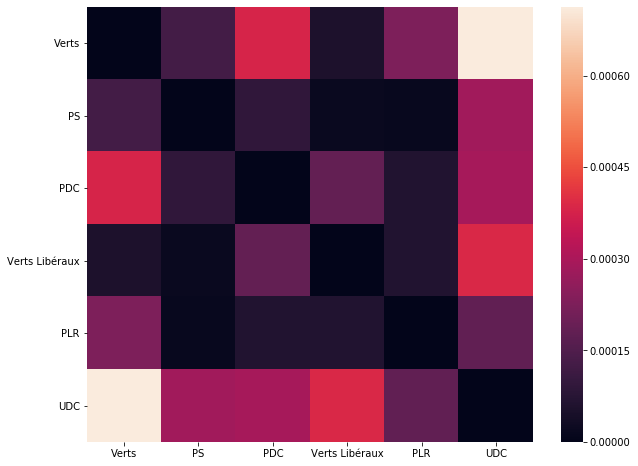

<Figure size 720x720 with 0 Axes>

In [60]:
means_parties = [mean_VERTS, mean_PS, mean_PDC, mean_VERTS_LIB, mean_PLR, mean_UDC]
parties = ["Verts", "PS", "PDC", "Verts Libéraux","PLR", "UDC"]

similiraties = np.zeros((6,6))
for i in range(0,6):
    for j in range(0,6):
        similiraties[i][j] = spatial.distance.cosine(means_parties[i], means_parties[j])

fig, ax = plt.pyplot.subplots(figsize=(10,8)) 
sns.heatmap(similiraties, xticklabels=parties, yticklabels=parties, ax=ax)
plt.pyplot.figure(figsize=[10,10])
plt.pyplot.show()

In [61]:
mean2_VERTS = mean_list_word(VERTS_text.split(" "), model)
mean2_UDC = mean_list_word(UDC_text.split(" "), model)
mean2_PS = mean_list_word(PS_text.split(" "), model)
mean2_PLR = mean_list_word(PLR_text.split(" "), model)
mean2_PDC = mean_list_word(PDC_text.split(" "), model)
mean2_VERTS_LIB = mean_list_word(VERTS_LIB_text.split(" "), model)

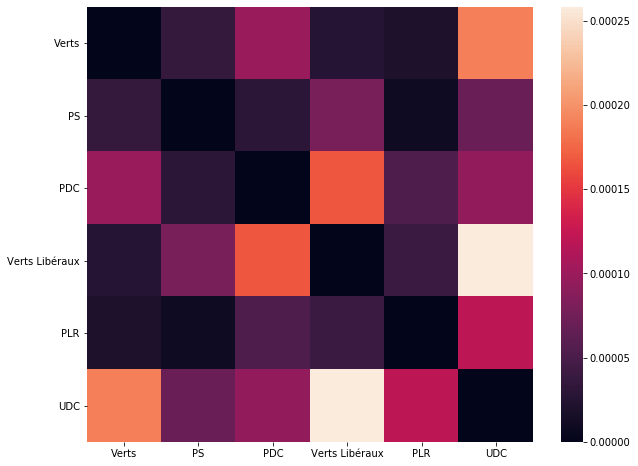

<Figure size 720x720 with 0 Axes>

In [62]:
means2_parties = [mean2_VERTS, mean2_PS, mean2_PDC, mean2_VERTS_LIB, mean2_PLR, mean2_UDC]
parties = ["Verts", "PS", "PDC", "Verts Libéraux","PLR", "UDC"]

similiraties2 = np.zeros((6,6))
for i in range(0,6):
    for j in range(0,6):
        similiraties2[i][j] = spatial.distance.cosine(means2_parties[i], means2_parties[j])
        
fig, ax = plt.pyplot.subplots(figsize=(10,8)) 
sns.heatmap(similiraties2, xticklabels=parties, yticklabels=parties, ax=ax)
plt.pyplot.figure(figsize=[10,10])
plt.pyplot.show()

# Use a dictionary

In [63]:
with open('data/frenchwords', 'r',  encoding="utf-8") as file:
    french_words = file.read().replace('\n', '|')

In [64]:
PLR_dict_text_list = tweets_to_text(tweets, lang='fr', party_name='PLR Suisse', dictionary_words= True, dictionary =french_words)

In [65]:
VERTS_dict_text_list = tweets_to_text(tweets, lang='fr', party_name= 'Les VERTS suisses 🌻', dictionary_words= True, dictionary = french_words)

In [66]:
UDC_dict_text_list = tweets_to_text(tweets, lang='fr', party_name='UDC Suisse', dictionary_words= True, dictionary = french_words)

In [67]:
PDC_dict_text_list = tweets_to_text(tweets, lang='fr', party_name='CVP PDC PPD PCD', dictionary_words= True, dictionary = french_words)

In [68]:
PS_dict_text_list = tweets_to_text(tweets, lang='fr', party_name='PS Suisse', dictionary_words= True, dictionary = french_words)

In [69]:
VERTS_LIB_dict_text_list= tweets_to_text(tweets, lang='fr', party_name="Vert'libéraux Suisse", dictionary_words= True, dictionary = french_words)

In [70]:
PLR_dict_text = " ".join(PLR_dict_text_list)

In [71]:
VERTS_dict_text = " ".join(VERTS_dict_text_list)

In [72]:
UDC_dict_text = " ".join(UDC_dict_text_list)

In [73]:
PDC_dict_text = " ".join(PDC_dict_text_list)

In [74]:
PS_dict_text = " ".join(PS_dict_text_list)

In [75]:
VERTS_LIB_dict_text = " ".join(VERTS_LIB_dict_text_list)

In [76]:
PLR_dict_bag = text_to_bag(PLR_dict_text, dictionary_words = True)

In [77]:
VERTS_dict_bag = text_to_bag(VERTS_dict_text, dictionary_words = True)

In [78]:
UDC_dict_bag = text_to_bag(UDC_dict_text, dictionary_words = True)

In [79]:
PDC_dict_bag = text_to_bag(PDC_dict_text, dictionary_words = True)

In [80]:
PS_dict_bag = text_to_bag(PS_dict_text, dictionary_words = True)

In [81]:
VERTS_LIB_dict_bag = text_to_bag(VERTS_LIB_dict_text, dictionary_words = True)

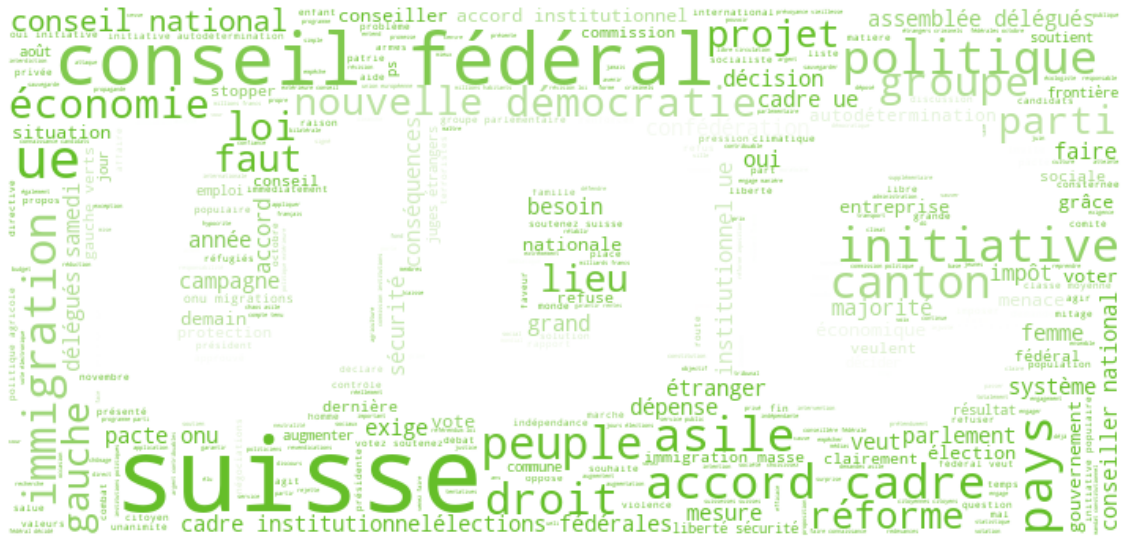

In [82]:
draw_wordcloud("data/logo/UDC_logo.jpg", UDC_dict_text)

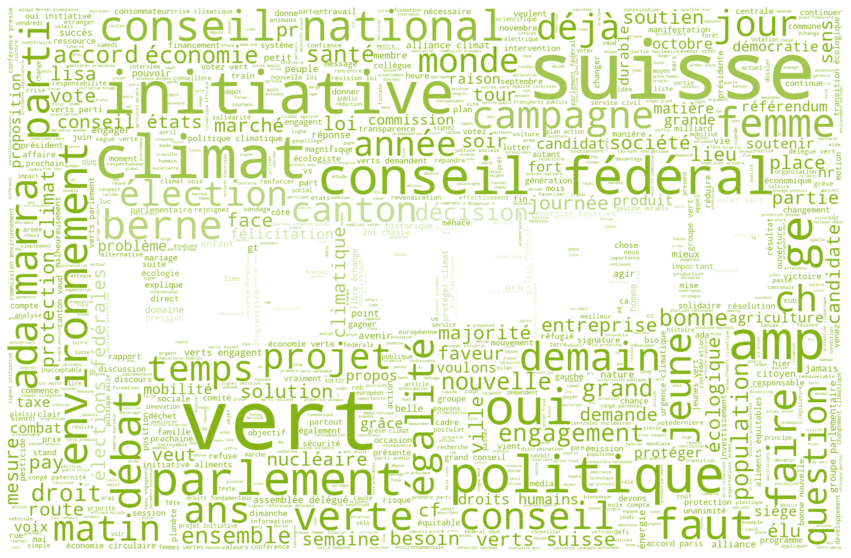

In [83]:
draw_wordcloud("data/logo/VERTS_logo.png", VERTS_dict_text)

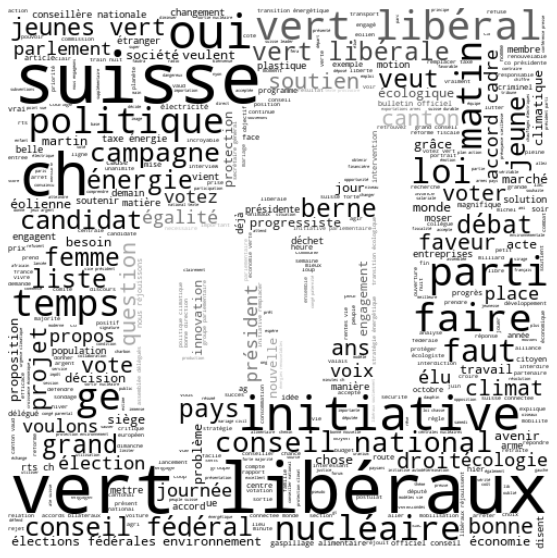

In [84]:
draw_wordcloud("data/logo/VERTS_LIB_logo.png", VERTS_LIB_dict_text)

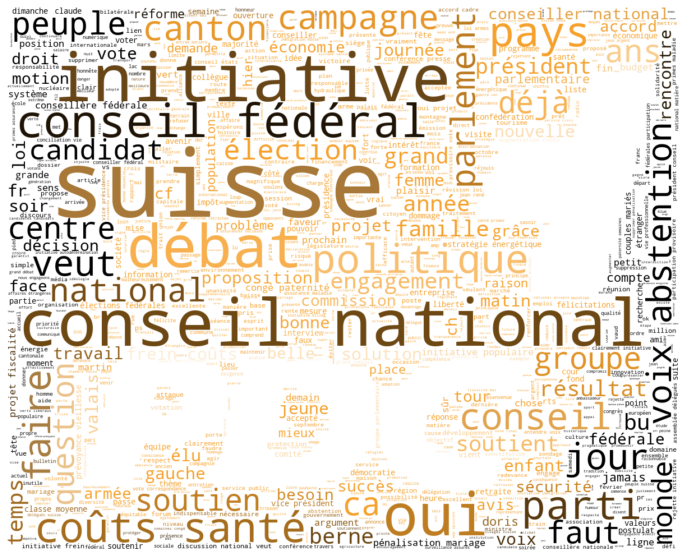

In [85]:
draw_wordcloud("data/logo/PDC_logo.png", PDC_dict_text)

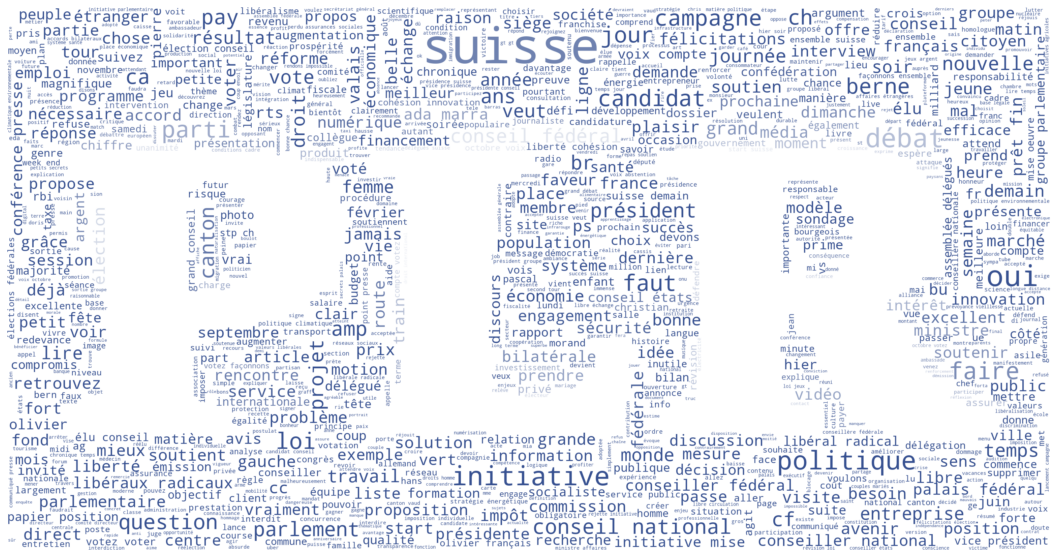

In [86]:
draw_wordcloud("data/logo/PLR_logo.png", PLR_dict_text)

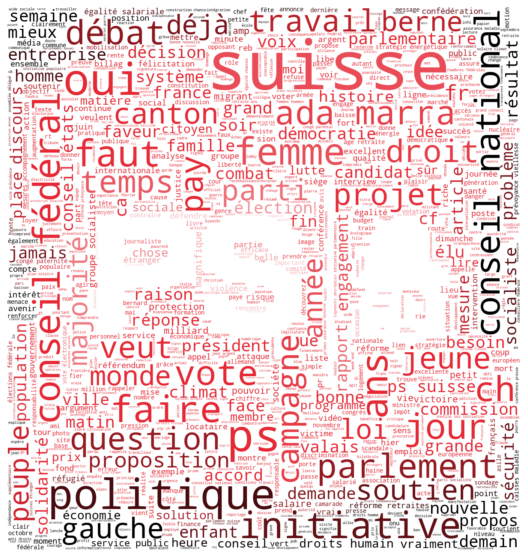

In [87]:
draw_wordcloud("data/logo/PS_logo.png", PS_dict_text)

# Evolution over time

In [95]:
def tweets_to_keywords_frequency_by_year(tweets, party_name, lang='fr'):
    """
    Compute the keywords frequency of the parties by year
    
    party_name: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    """
    keywords_frequency = []
    for year in [[2015],[2016],[2017],[2018],[2019]]:
        keywords_frequency.append(bag_to_keywords_frequency(text_to_bag(tweets_to_text(tweets, lang="fr", party_name=party_name, year=year)), topic_list_reg))
    return keywords_frequency

In [99]:
def plot_keywords_frequency_by_year(keywords_frequency):
    """
    Plot the keywords frequency by year
    """
    years = np.arange(2015, 2020)

    fig, ax = plt.pyplot.subplots()

    for topic in topic_list_reg:
        y = []
        for i in range(0, len(years)):
            y.append(keywords_frequency[i][topic])
        y = np.array(y)
        ax.plot(years, y, label=topic)
    
    ax.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)   
    plt.pyplot.show()

In [100]:
VERTS_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "Les VERTS suisses 🌻")
VERTS_keywords_frequency

[{'Climate': 24.834437086092716,
  'Immigration': 14.56953642384106,
  'Safety': 3.642384105960265,
  'Liberty': 1.3245033112582782,
  'Egality': 7.28476821192053,
  'Economy': 15.562913907284768,
  'Work': 7.947019867549669,
  'Women': 1.3245033112582782,
  'Digital': 1.3245033112582782,
  'Family': 7.28476821192053,
  'AVS': 2.6490066225165565,
  'Health': 4.966887417218543,
  'Europe': 3.9735099337748343,
  'Army': 3.3112582781456954},
 {'Climate': 8.870967741935484,
  'Immigration': 12.903225806451612,
  'Safety': 4.838709677419355,
  'Liberty': 2.4193548387096775,
  'Egality': 4.032258064516129,
  'Economy': 39.516129032258064,
  'Work': 5.645161290322581,
  'Women': 0.8064516129032258,
  'Digital': 0.8064516129032258,
  'Family': 5.645161290322581,
  'AVS': 4.032258064516129,
  'Health': 1.6129032258064515,
  'Europe': 6.451612903225806,
  'Army': 2.4193548387096775},
 {'Climate': 30.64516129032258,
  'Immigration': 4.838709677419355,
  'Safety': 10.21505376344086,
  'Liberty': 2

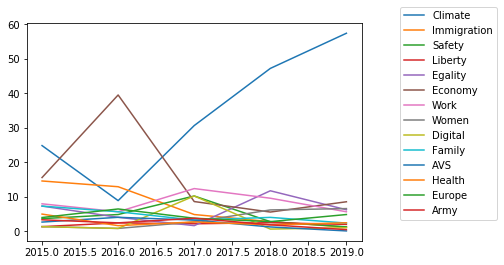

In [101]:
plot_keywords_frequency_by_year(VERTS_keywords_frequency)

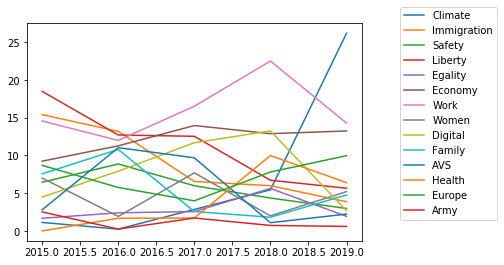

In [102]:
PLR_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "PLR Suisse")
plot_keywords_frequency_by_year(PLR_keywords_frequency)

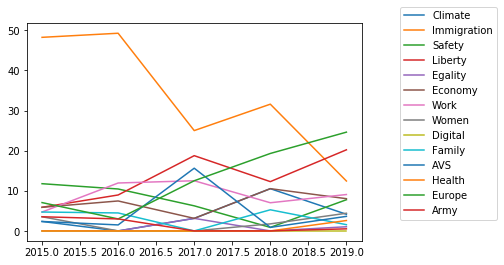

In [103]:
UDC_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "UDC Suisse")
plot_keywords_frequency_by_year(UDC_keywords_frequency)

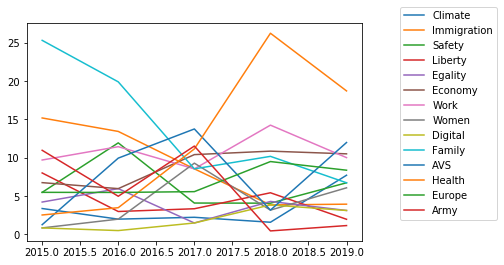

In [104]:
PDC_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "CVP PDC PPD PCD")
plot_keywords_frequency_by_year(PDC_keywords_frequency)

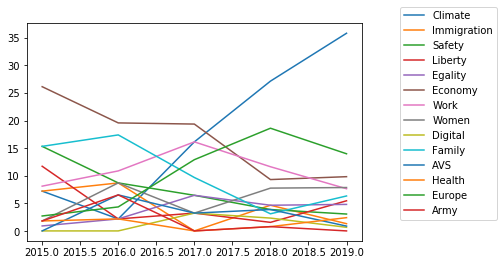

In [105]:
VERTS_LIB_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "Vert'libéraux Suisse")
plot_keywords_frequency_by_year(VERTS_LIB_keywords_frequency)

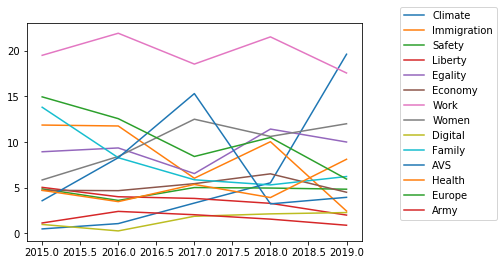

In [106]:
PS_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "PS Suisse")
plot_keywords_frequency_by_year(PS_keywords_frequency)

# Which party talks more about the other

In [107]:
party_names = {'UDC':r'\budc|\bsvp|\bunion démocratique du centre|\bunion démocratique' ,
                'PLR':r'\bplr|\blibéraux-radicaux|\blibéraux radicaux|\bfdp',
                'PS':r'\bps|\bsp|\bsocialiste|\bpss|\bsocialistes',
                'VERTS':r'\bparti écologiste suisse|\bverts|\bpes|\bécologiste',
                'PVL':r"\bpvl\bvert'lib|\bvert'libéraux|\bvert libéraux|\bvert libéral",
                'PDC':r"\bdémocrate-chrétien|\bdémocrate|\bchretien|\bpdc|\bppd|\bcvp"}

In [108]:
def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

In [109]:
def party_name_frequency(party_text, party_name):
    other_parties = without_keys(party_names, party_name)
    frequency_dict = {}
    total = 0
    for key, value in other_parties.items():
        n_occurences = len(re.findall(value, party_text, flags=re.IGNORECASE))           
        frequency_dict.update({key:n_occurences})
        total += n_occurences
    for key, value in frequency_dict.items():
        frequency_dict.update({key:100*int(value)/total})

    return frequency_dict


In [110]:
UDC_frequency = party_name_frequency(UDC_text, 'UDC')
UDC_frequency

{'PLR': 19.767441860465116,
 'PS': 34.883720930232556,
 'VERTS': 30.232558139534884,
 'PVL': 0.0,
 'PDC': 15.116279069767442}

In [111]:
PLR_frequency = party_name_frequency(PLR_text, 'PLR')
PLR_frequency

{'UDC': 21.556122448979593,
 'PS': 48.08673469387755,
 'VERTS': 8.290816326530612,
 'PVL': 0.3826530612244898,
 'PDC': 21.683673469387756}

In [112]:
PDC_frequency = party_name_frequency(PDC_text, 'PDC')
PDC_frequency

{'UDC': 31.185567010309278,
 'PLR': 21.649484536082475,
 'PS': 34.27835051546392,
 'VERTS': 12.371134020618557,
 'PVL': 0.5154639175257731}

In [113]:
PVL_frequency = party_name_frequency(VERTS_LIB_text, 'PVL')
PVL_frequency

{'UDC': 28.32764505119454,
 'PLR': 15.017064846416382,
 'PS': 19.112627986348123,
 'VERTS': 21.843003412969285,
 'PDC': 15.699658703071673}

In [114]:
VERTS_frequency = party_name_frequency(VERTS_text, 'VERTS')
VERTS_frequency

{'UDC': 20.74074074074074,
 'PLR': 20.74074074074074,
 'PS': 43.20987654320987,
 'PVL': 0.7407407407407407,
 'PDC': 14.567901234567902}

# Analysing tweets influence

In [115]:
def rt_favorites(tweets, party_name, year=YEARS):
    """
    Returns a text of all the tweets of a party after processing them.
    
    lang: {'fr','de'}
    username: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    year: default = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
    """
    tweets_copy = tweets.copy()
    tweets_copy = tweets_copy[tweets_copy.party_name==party_name]
    tweets_copy = tweets_copy[tweets_copy['year'].isin(year)]
    tweets_copy = tweets_copy[~tweets_copy.tweet_text.str.startswith("RT")]
    tweets_copy = tweets_copy[["party_name", "tweet_text", "retweet_count", "favorite_count"]]

    return tweets_copy


In [116]:
VERTS_rt = rt_favorites(tweets,  party_name='Les VERTS suisses 🌻')
UDC_rt = rt_favorites(tweets,  party_name='UDC Suisse')
PLR_rt = rt_favorites(tweets, party_name='PLR Suisse')
PDC_rt = rt_favorites(tweets, party_name='CVP PDC PPD PCD')
PS_rt = rt_favorites(tweets, party_name='PS Suisse')
PVL_rt = rt_favorites(tweets, party_name="Vert'libéraux Suisse")

In [117]:
VERTS_desc = VERTS_rt.describe()
VERTS_desc

retweet_count  favorite_count
count   12890.000000    12890.000000
mean        3.892552       10.366020
std         8.921734       20.741531
min         0.000000        0.000000
25%         0.000000        1.000000
50%         2.000000        3.000000
75%         5.000000       12.000000
max       728.000000      612.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001724120B438>,
      dtype=object)

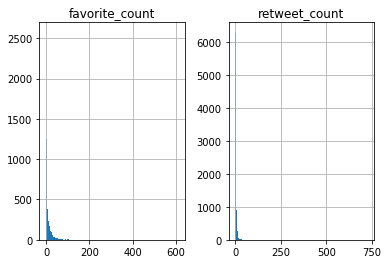

In [118]:
VERTS_rt.hist(bins=int(min(VERTS_desc.loc["max"][0], VERTS_desc.loc["max"][1])))

In [119]:
UDC_desc = UDC_rt.describe()
UDC_desc

retweet_count  favorite_count
count    8545.000000     8545.000000
mean        4.025863       13.676185
std         9.589792       26.105580
min         0.000000        0.000000
25%         0.000000        1.000000
50%         2.000000        5.000000
75%         5.000000       15.000000
max       641.000000     1070.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001724293A2B0>,
      dtype=object)

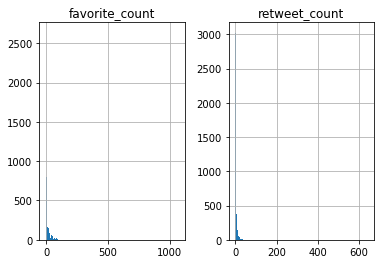

In [120]:
UDC_rt.hist(bins=int(min(UDC_desc.loc["max"][0], UDC_desc.loc["max"][1])))

In [121]:
PDC_desc = PDC_rt.describe()
PDC_desc

retweet_count  favorite_count
count   25439.000000    25439.000000
mean        1.451472        5.598962
std         3.294874       14.658570
min         0.000000        0.000000
25%         0.000000        0.000000
50%         0.000000        2.000000
75%         1.000000        6.000000
max        78.000000      705.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000172412BD470>,
      dtype=object)

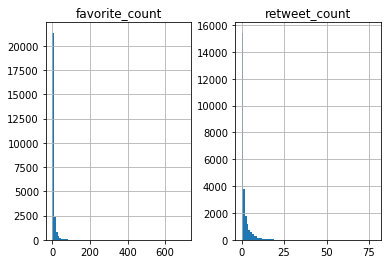

In [122]:
PDC_rt.hist(bins=int(min(PDC_desc.loc["max"][0], PDC_desc.loc["max"][1])))

In [123]:
PLR_desc = PLR_rt.describe()
PLR_desc

retweet_count  favorite_count
count   17274.000000    17274.000000
mean        1.990680        7.629327
std         4.286783       15.857945
min         0.000000        0.000000
25%         0.000000        0.000000
50%         0.000000        2.000000
75%         2.000000        8.000000
max        92.000000      411.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017241F16D68>,
      dtype=object)

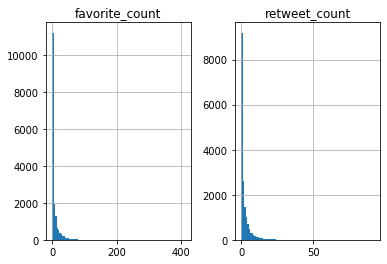

In [124]:
PLR_rt.hist(bins=int(min(PLR_desc.loc["max"][0], PLR_desc.loc["max"][1])))

In [125]:
PS_desc = PS_rt.describe()
PS_desc

retweet_count  favorite_count
count   27000.000000    27000.000000
mean        2.911296        8.493519
std        41.500779       58.010439
min         0.000000        0.000000
25%         0.000000        0.000000
50%         0.000000        2.000000
75%         2.000000        7.000000
max      4338.000000     7508.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001724227AFD0>,
      dtype=object)

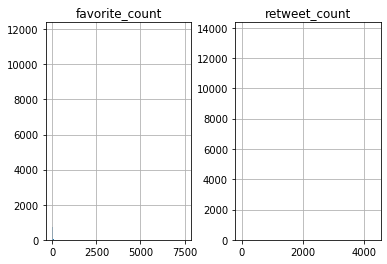

In [126]:
PS_rt.hist(bins=int(min(PS_desc.loc["max"][0], PS_desc.loc["max"][1])))

In [127]:
PVL_desc = PVL_rt.describe()
PVL_desc

retweet_count  favorite_count
count    5590.000000     5590.000000
mean        4.168336       13.490519
std         6.856667       21.264436
min         0.000000        0.000000
25%         0.000000        1.000000
50%         1.000000        5.000000
75%         6.000000       18.000000
max        89.000000      238.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000172422E5A58>,
      dtype=object)

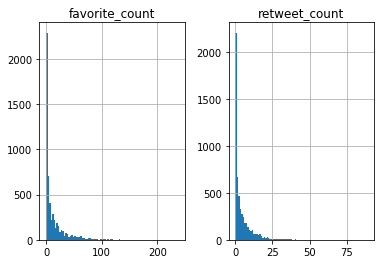

In [128]:
PVL_rt.hist(bins=int(min(PVL_desc.loc["max"][0], PVL_desc.loc["max"][1])))